In [3499]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy.stats import ttest_ind
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb

In [3500]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.", category=UserWarning)
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.", category=UserWarning)

# Load Data

In [3501]:
calls = pd.read_csv('/Users/pendovka/Desktop/Data/Central Intake Service Queue Data.csv')
calls['Date'] = pd.to_datetime(calls['Date'])
calls.set_index('Date', inplace=True)  

In [3502]:
occupancy = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2023.csv')

occupancy['OCCUPANCY_DATE'] = pd.to_datetime(occupancy['OCCUPANCY_DATE'])
occupancy.set_index('_id', inplace=True, drop=True)

occupancy.set_index('OCCUPANCY_DATE', inplace=True)
monthly_average_occupancy_rate = occupancy['OCCUPANCY_RATE_BEDS'].resample('MS').mean()

In [3503]:
shelter_flow = pd.read_csv('/Users/pendovka/Desktop/Data/toronto-shelter-system-flow.csv')
shelter_flow.rename(columns={'date(mmm-yy)': 'Date'}, inplace=True)
shelter_flow['Date'] = pd.to_datetime(shelter_flow['Date'], format='%b-%y')
shelter_flow = shelter_flow.set_index('Date')

In [3504]:
calls_full = pd.read_csv('/Users/pendovka/Desktop/Data/Central Intake Call Wrap-Up Codes Data.csv')
calls_full['Date'] = pd.to_datetime(calls_full['Date'])
calls_full.set_index('Date', inplace=True)
calls_full.rename(columns={'Code 3B - Shelter Space Unavailable - Individuals/Couples': 'shelter_unavailable_ind'}, inplace=True)
calls_full.rename(columns={'Total calls handled': 'total_calls_handled'}, inplace=True)


In [3505]:
weather20 = pd.read_csv('/Users/pendovka/Desktop/Data/toronto_weather_20.csv')
weather21 = pd.read_csv('/Users/pendovka/Desktop/Data/toronto_weather_21.csv')
weather22 = pd.read_csv('/Users/pendovka/Desktop/Data/toronto_weather_22.csv')
weather23 = pd.read_csv('/Users/pendovka/Desktop/Data/toronto_weather_23.csv')

weather = pd.concat([weather20, weather21, weather22, weather23])

weather = weather.rename(columns={'Date/Time': 'Date', 'Min Temp (°C)': 'min_temp_cels', 'Total Precip (mm)': 'total_precip_mm'})

weather['Date'] = pd.to_datetime(weather['Date']) 
weather.set_index('Date', inplace=True)

weather = weather[['min_temp_cels', 'total_precip_mm']]
weather['min_temp_cels'] = weather['min_temp_cels'].interpolate(method='linear')
weather['total_precip_mm'] = weather['total_precip_mm'].interpolate(method='linear')

weather['day_of_week'] = weather.index.dayofweek
dummy_variables = pd.get_dummies(weather['day_of_week'], prefix='day')
dummy_variables = dummy_variables.astype(int)

dummy_variables = dummy_variables.drop(columns='day_0')

weather = pd.concat([weather, dummy_variables], axis=1)

# Initial Correlation Analysis

In [3506]:
average_daily_calls_unavailable = calls_full['shelter_unavailable_ind'].resample('MS').mean()
average_daily_total_calls = calls_full['total_calls_handled'].resample('MS').mean().rename('average_daily_total_calls')

monthly_calls = pd.merge(average_daily_calls_unavailable, average_daily_total_calls, on='Date', how='inner')
monthly_calls['unavailable_ratio'] = monthly_calls['shelter_unavailable_ind'] / monthly_calls['average_daily_total_calls']

shelter_flow = shelter_flow[shelter_flow['population_group'] == 'All Population']

average_daily_unmatched = calls['Unmatched callers'].resample('MS').mean().rename('average_daily_unmatched_callers')
monthly_calls_merge = pd.merge(monthly_calls, average_daily_unmatched , on= 'Date', how='inner')

In [3507]:
merged_calls_flow_monthly = pd.merge(monthly_calls_merge, shelter_flow, left_index=True, right_index=True, how='inner')

merged_calls_flow_monthly = merged_calls_flow_monthly[merged_calls_flow_monthly.index.year < 2024]

merged_calls_flow_monthly.reset_index(inplace=True)

merged_calls_flow_monthly = merged_calls_flow_monthly[['Date', 'average_daily_total_calls', 'average_daily_unmatched_callers', 'newly_identified', 'actively_homeless', 'became_inactive', 'returned_to_shelter']]

correlation_calls_newlyhomeless = merged_calls_flow_monthly[['average_daily_unmatched_callers', 'newly_identified']].corr().iloc[0, 1]
correlation_calls_activelyhomeless = merged_calls_flow_monthly[['average_daily_unmatched_callers', 'actively_homeless']].corr().iloc[0, 1]
correlation_calls_inactive = merged_calls_flow_monthly[['average_daily_unmatched_callers', 'became_inactive']].corr().iloc[0, 1]

print(f"Correlation between the number of unmatched callers and newly homeless: {correlation_calls_newlyhomeless:.2f}")
print(f"Correlation between the number of unmatched callers and actively homeless: {correlation_calls_activelyhomeless:.2f}")
print(f"Correlation between the number of unmatched callers and inactive homeless: {correlation_calls_inactive:.2f}")

Correlation between the number of unmatched callers and newly homeless: 0.35
Correlation between the number of unmatched callers and actively homeless: 0.65
Correlation between the number of unmatched callers and inactive homeless: -0.35


# Merge all occupancy tables

In [3508]:
occupancy2024 = pd.read_csv('/Users/pendovka/Desktop/Data/Daily shelter overnight occupancy.csv')
occupancy2023 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2023.csv')
occupancy2022 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2022.csv')
occupancy2021 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2021.csv')

occupancy2021['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2021['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
occupancy2022['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2022['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
occupancy2023['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2023['OCCUPANCY_DATE'])
occupancy2024['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2024['OCCUPANCY_DATE'])
occupancy2024.head()

concatenated_occupancy = pd.concat([occupancy2024, occupancy2023, occupancy2022, occupancy2021])
concatenated_occupancy['OCCUPANCY_DATE'] = pd.to_datetime(concatenated_occupancy['OCCUPANCY_DATE'])
concatenated_occupancy.sort_values(by='OCCUPANCY_DATE', inplace=True)
concatenated_occupancy.set_index('OCCUPANCY_DATE', inplace=True)

concatenated_occupancy['CAPACITY_ACTUAL_ROOM'] = concatenated_occupancy['CAPACITY_ACTUAL_ROOM'].fillna(0).astype(int)
concatenated_occupancy['CAPACITY_ACTUAL_BED'] = concatenated_occupancy['CAPACITY_ACTUAL_BED'].fillna(0).astype(int)
concatenated_occupancy['OCCUPANCY_RATE_BEDS'] = concatenated_occupancy['OCCUPANCY_RATE_BEDS'].fillna(0).astype(int)
concatenated_occupancy['OCCUPANCY_RATE_ROOMS'] = concatenated_occupancy['OCCUPANCY_RATE_ROOMS'].fillna(0).astype(int)

concatenated_occupancy['occupancy_rate'] = concatenated_occupancy['OCCUPANCY_RATE_BEDS'] + concatenated_occupancy['OCCUPANCY_RATE_ROOMS']
concatenated_occupancy['capacity'] = concatenated_occupancy['CAPACITY_ACTUAL_ROOM'] + concatenated_occupancy['CAPACITY_ACTUAL_BED']

concatenated_occupancy = concatenated_occupancy.rename_axis('Date')

concatenated_occupancy.head()

,_id,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,...,UNAVAILABLE_BEDS,CAPACITY_ACTUAL_ROOM,CAPACITY_FUNDING_ROOM,OCCUPIED_ROOMS,UNOCCUPIED_ROOMS,UNAVAILABLE_ROOMS,OCCUPANCY_RATE_BEDS,OCCUPANCY_RATE_ROOMS,occupancy_rate,capacity
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,1,24,COSTI Immigrant Services,40,COSTI Reception Centre,1103.0,COSTI/City North York West Hotel Program,1677 Wilson Ave,M3L 1A5,North York,...,NaN,29,58.0,26.0,3.0,29.0,0,89,89,29
2021-01-01,105,34,St. Felix Social Ministries Outreach,66,St. Felix Centre,1148.0,St. Felix Centre 69 Fraser Ave. Respite,69 Fraser Ave,M6K 1E9,Toronto,...,0.0,0,NaN,NaN,NaN,NaN,100,0,100,43
2021-01-01,104,34,St. Felix Social Ministries Outreach,66,St. Felix Centre,1105.0,St. Felix Centre 25 Augusta Ave. Respite,25 Augusta Ave,M5T 2K7,Toronto,...,0.0,0,NaN,NaN,NaN,NaN,100,0,100,19
2021-01-01,103,19,Society of St.Vincent De Paul,31,SVDP - St. Clare's Residence,1039.0,SVDP St. Clare's Residence,3410 Bayview Ave,M2M 3S3,Toronto,...,4.0,0,NaN,NaN,NaN,NaN,96,0,96,26
2021-01-01,102,19,Society of St.Vincent De Paul,37,SVDP - Mary's Home,1048.0,SVDP Mary's Home,70 Gerrard St E,M5B 1G6,Toronto,...,15.0,0,NaN,NaN,NaN,NaN,100,0,100,12


We need to focus on Motel/Hotel type of shelters since they have adjustable capacity. Let's calculate averate daily capacity for for these.

In [3509]:
concatenated_occupancy_flexible = concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Motel/Hotel Shelter'].copy()

grouped_unflexible = concatenated_occupancy_flexible.groupby('Date').agg({'capacity': 'sum', 'occupancy_rate': 'mean'})

average_daily_capacity = grouped_unflexible.resample('MS').mean().rename(columns={'capacity': 'average_daily_adjustable_capacity', 'occupancy_rate': 'average_daily_occupancy_rate_adjustable'}).round(2)

capacity_adjustable_shelter = average_daily_capacity['average_daily_adjustable_capacity'].mean()

In [3510]:
merged_calls_occupancy_flow_monthly = pd.merge(average_daily_capacity, merged_calls_flow_monthly, left_index=True, right_on='Date', how='inner')

date_column = merged_calls_occupancy_flow_monthly['Date']
merged_calls_occupancy_flow_monthly.drop(columns=['Date'], inplace=True)
merged_calls_occupancy_flow_monthly.insert(0, 'Date', date_column)
merged_calls_occupancy_flow_monthly.set_index('Date', inplace=True)


In [3511]:
concatenated_occupancy_unflexible = concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Shelter'].copy()

grouped_unflexible = concatenated_occupancy_unflexible.groupby('Date').agg({'capacity': 'sum', 'occupancy_rate': 'mean'})

average_other_daily_capacity = grouped_unflexible.resample('MS').mean().rename(columns={'capacity': 'average_daily_nonadjustable_capacity', 'occupancy_rate': 'average_daily_occupancy_rate_nonadjustable'}).round(2)

capacity_non_adjustable_shelter = average_other_daily_capacity['average_daily_nonadjustable_capacity'].mean()

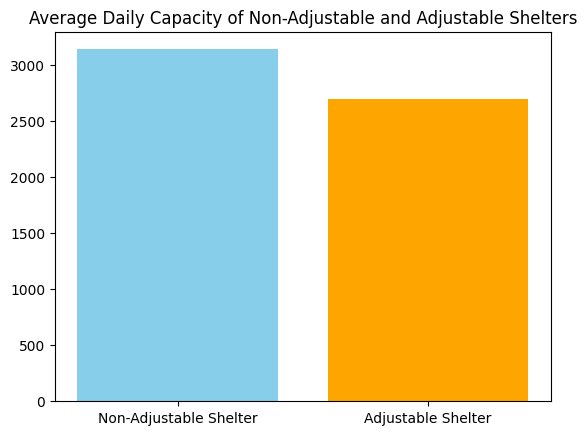

In [3512]:
bar_positions = [0, 1]
bar_heights = [capacity_non_adjustable_shelter, capacity_adjustable_shelter]
bar_colors = ['skyblue', 'orange']

plt.bar(bar_positions, bar_heights, color=bar_colors)
plt.xticks(bar_positions, ['Non-Adjustable Shelter', 'Adjustable Shelter'])

plt.title('Average Daily Capacity of Non-Adjustable and Adjustable Shelters')
plt.show()

# Merged dataset 

In [3513]:
merged_calls_occupancy_flow_monthly = pd.merge(average_other_daily_capacity, merged_calls_occupancy_flow_monthly, how='inner', left_index=True, right_index=True)

merged_calls_occupancy_flow_monthly[['average_daily_total_calls', 'average_daily_unmatched_callers']] = merged_calls_occupancy_flow_monthly[['average_daily_total_calls', 'average_daily_unmatched_callers']].round(2)
merged_calls_occupancy_flow_monthly.tail()

,average_daily_nonadjustable_capacity,average_daily_occupancy_rate_nonadjustable,average_daily_adjustable_capacity,average_daily_occupancy_rate_adjustable,average_daily_total_calls,average_daily_unmatched_callers,newly_identified,actively_homeless,became_inactive,returned_to_shelter
Date,,,,,,,,,,
2023-08-01,3829.71,98.26,2483.87,99.39,888.32,244.26,539,9988,632,201
2023-09-01,3979.63,97.61,2471.83,99.66,979.87,277.97,841,10212,483,194
2023-10-01,4077.35,97.40,2496.16,99.52,1094.16,291.29,929,10111,502,165
2023-11-01,4132.60,97.54,2481.33,99.51,969.90,245.30,1113,10498,472,267
2023-12-01,4196.26,97.08,2475.77,99.55,805.94,164.74,886,10607,447,266


# Exploratory Data Analysis

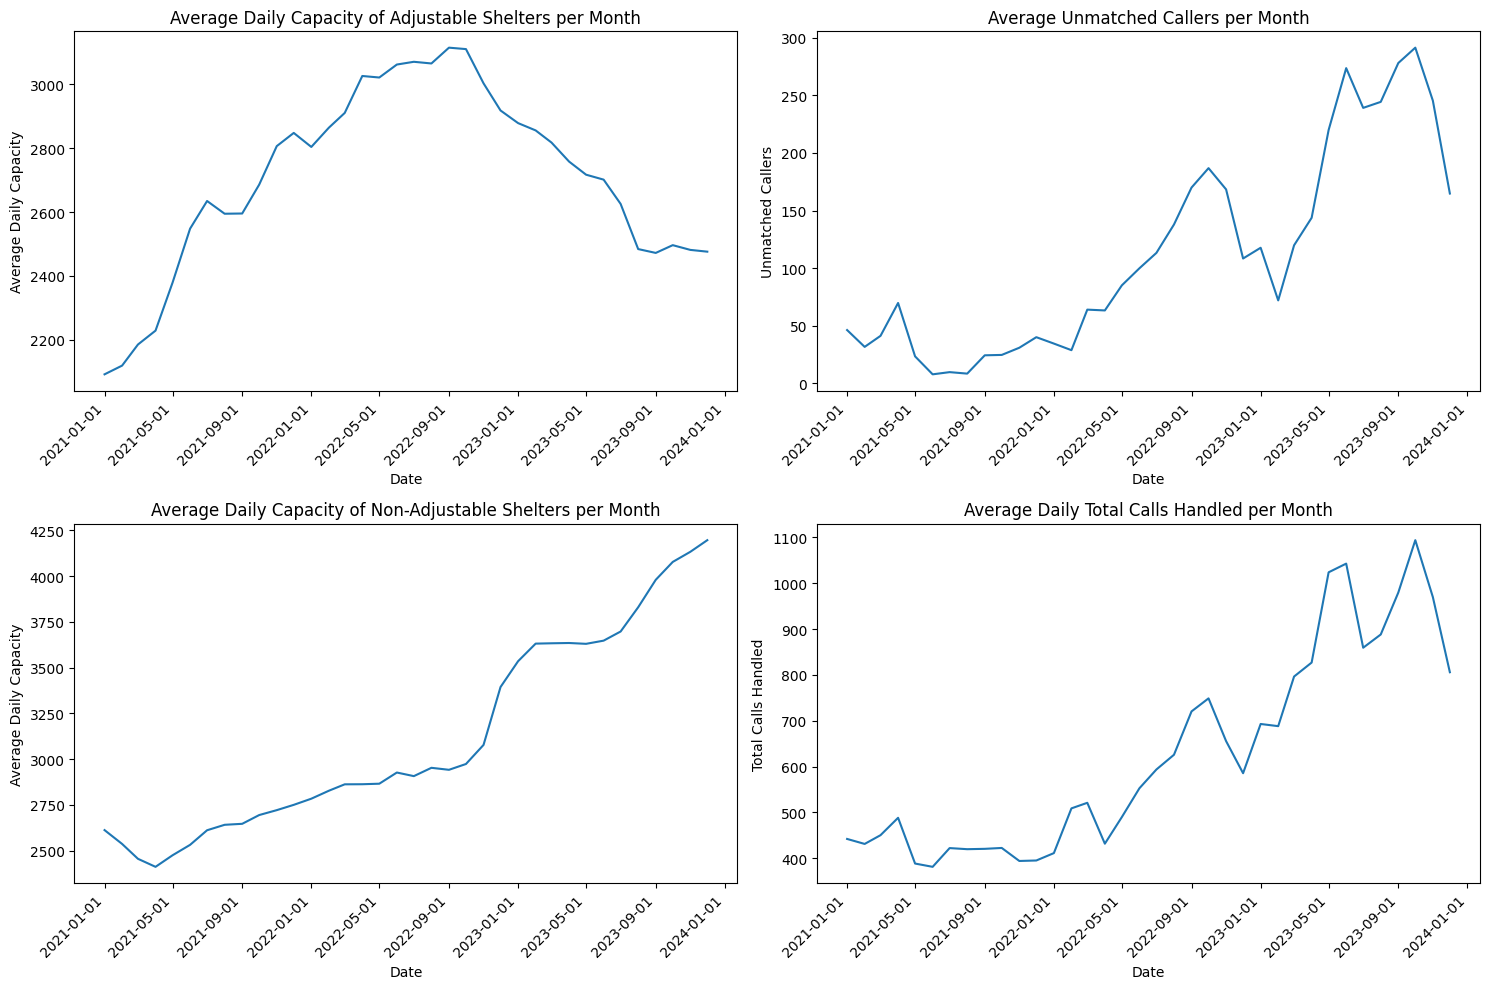

In [3514]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

plt.subplot(2, 2, 1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot1 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_adjustable_capacity')
    plot1.set_xticks(plot1.get_xticks())  # Set the x-axis tick positions
    plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Average Daily Capacity')
plt.title('Average Daily Capacity of Adjustable Shelters per Month')

plt.subplot(2, 2, 2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot2 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_unmatched_callers')
    plot2.set_xticks(plot2.get_xticks())  # Set the x-axis tick positions
    plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Unmatched Callers')
plt.title('Average Unmatched Callers per Month')

plt.subplot(2, 2, 3)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot3 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_nonadjustable_capacity')
    plot3.set_xticks(plot3.get_xticks())  # Set the x-axis tick positions
    plot3.set_xticklabels(plot3.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Average Daily Capacity')
plt.title('Average Daily Capacity of Non-Adjustable Shelters per Month')

plt.subplot(2, 2, 4)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot4 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_total_calls')
    plot4.set_xticks(plot4.get_xticks())  # Set the x-axis tick positions
    plot4.set_xticklabels(plot4.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Total Calls Handled')
plt.title('Average Daily Total Calls Handled per Month')

plt.tight_layout()
plt.show()

newly_identified – people who entered the shelter system for the first time. We see a constant rate of shelters inflow here <br>
became_inactive – people who were using the shelter system previously, but have not used the shelter system in the past three months.<br><br>
Seasonality is not correlated with the average number of calls. However, it is correlated with the demand for shelters – we see the spikes in the number of newly_identified shelter users in winter months; conversely, the highest number of people who stopped using shelters is observed during the summer monhts.<br><br>
Seasonality is also somewhat correlated with the adjustable occupancy rate: 17.3% compared to 2.4% for nonadjustable. This could mean that the city does indeed adjust the capacity in response to change of seasons.

# T-tests

average_daily_total_calls: 
t-statistic: -6.88893413600925
p-value: 1.7353481576535172e-07 

average_daily_unmatched_callers: 
t-statistic: -4.61201517413596
p-value: 8.006545614428855e-05 

newly_identified: 
t-statistic: 0.16602987177514428
p-value: 0.8693265141990705 

became_inactive: 
t-statistic: -5.459332384784218
p-value: 7.913462469177361e-06 

returned_to_shelter: 
t-statistic: 9.903443022198156
p-value: 1.1918615747542516e-10 

average_daily_occupancy_rate_adjustable: 
t-statistic: -0.44383746320281786
p-value: 0.6605712129084421 

actively_homeless: 
t-statistic: 4.384850381562366
p-value: 0.00014862087847395002 



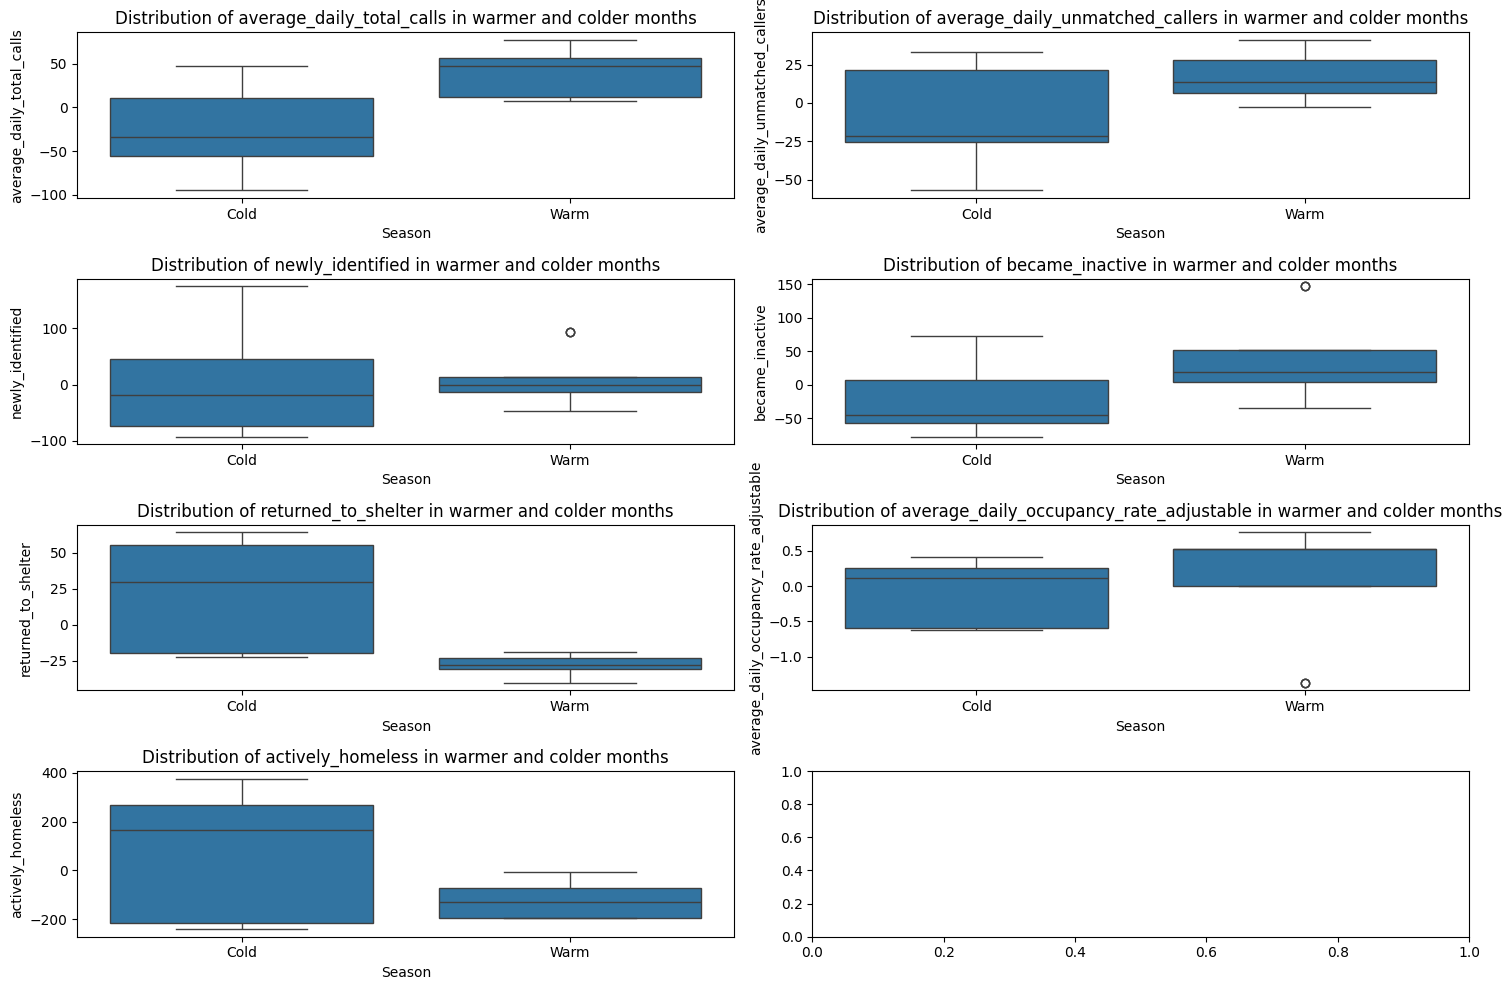

In [3515]:
variables = ['average_daily_total_calls', 'average_daily_unmatched_callers', 'newly_identified', 'became_inactive', 'returned_to_shelter', 'average_daily_occupancy_rate_adjustable', 'actively_homeless']

fig, axes = plt.subplots(4, 2, figsize=(15, 10))

axes = axes.flatten()

for i, variable in enumerate(variables):

    result = seasonal_decompose(merged_calls_occupancy_flow_monthly[variable])
    seasonal_data = pd.DataFrame({variable: result.seasonal})
    seasonal_data['Month'] = seasonal_data.index.month

    cold_months = [11, 12, 1, 2,3]
    warm_months = [5, 6, 7, 8,9]

    winter_values = seasonal_data[seasonal_data['Month'].isin(cold_months)][variable]
    summer_values = seasonal_data[seasonal_data['Month'].isin(warm_months)][variable]

    t_statistic, p_value = ttest_ind(winter_values, summer_values)

    seasonal_data['Season'] = np.where(seasonal_data['Month'].isin(warm_months), 'Warm', 'Cold')
    seasonal_data['Season'] = np.where(seasonal_data['Month'].isin(cold_months), 'Cold', seasonal_data['Season'])

    sns.boxplot(x='Season', y=variable, data=seasonal_data, order=['Cold', 'Warm'], ax=axes[i])
    axes[i].set_title(f'Distribution of {variable} in warmer and colder months')

    print(f"{variable}: \nt-statistic: {t_statistic}")
    print("p-value:", p_value, "\n")

plt.tight_layout()
plt.show()

The inflow of newly identified homeless people is approximately the same both in winter and summer. However, we can recognize a pattern of outflow and inflow of people who have used shelters at least once in warm and cold months respectively. That can explain the seasonal fluctuations in the number of actively homeless people.

Otherwise, seasonality can be associated the demand for shelters, albeit in an unexpected manner: we observe more calls made in warmer months compared to colder months. Similarly, the higher number of people get refused a shelter bed during the warmer months compared to winter months.

The disadvantage we have with this merged dataset is the limited number of datapoints due to the short history (only 3 years) of data collection, which results in only 36 monthly observations. 

# Feature Engineering

In [3516]:
merged_calls_daily = pd.merge(calls, calls_full, on = 'Date', how='inner')
merged_calls_daily = merged_calls_daily[['Unmatched callers', 'total_calls_handled']]

daily_average_occupancy_rate = concatenated_occupancy.groupby(concatenated_occupancy.index.date)['occupancy_rate'].mean().round(2)

merged_calls_occupancy_daily = pd.merge(daily_average_occupancy_rate, merged_calls_daily, left_index=True, right_index=True, how='inner')

merged_calls_occupancy_daily['cold_season'] = merged_calls_occupancy_daily.index.month.isin([11, 12, 1, 2, 3]).astype(int)

shelter_flow = shelter_flow[['returned_from_housing','returned_to_shelter', 'newly_identified', 'became_inactive']]

# Upsample shelter_flow to daily frequency
shelter_flow_daily = shelter_flow.resample('D').ffill()

# Ensure that the index contains datetime objects
shelter_flow_daily.index = pd.to_datetime(shelter_flow_daily.index)

# Merge the daily shelter_flow data with merged_calls_daily
merged_calls_occupancy_flow_daily = pd.merge(merged_calls_occupancy_daily, shelter_flow_daily, left_index=True, right_index=True, how='left')

# Reset index to ensure dates are not lost
merged_calls_occupancy_flow_daily.reset_index(inplace=True)
merged_calls_occupancy_flow_daily.ffill(inplace=True)
first_columns_to_int = ['returned_from_housing','returned_to_shelter', 'newly_identified', 'became_inactive']
merged_calls_occupancy_flow_daily[first_columns_to_int] = merged_calls_occupancy_flow_daily[first_columns_to_int].astype(int)

merged_calls_occupancy_flow_daily = merged_calls_occupancy_flow_daily.rename(columns={'index': 'Date'})
merged_calls_occupancy_flow_daily = merged_calls_occupancy_flow_daily.set_index('Date')

merged_calls_occupancy_flow_daily.head()

,occupancy_rate,Unmatched callers,total_calls_handled,cold_season,returned_from_housing,returned_to_shelter,newly_identified,became_inactive
Date,,,,,,,,
2021-01-01,92.83,19,305,1,84,425,647,660
2021-01-02,92.99,22,319,1,84,425,647,660
2021-01-03,92.64,28,281,1,84,425,647,660
2021-01-04,92.15,28,379,1,84,425,647,660
2021-01-05,92.06,45,461,1,84,425,647,660


In [3517]:
merged_calls_occupancy_flow_daily = merged_calls_occupancy_flow_daily.rename(columns={'Unmatched callers' : 'unmatched_callers'})
#columns_to_drop = ['occupancy_rate', 'total_calls_handled', 'newly_identified', 'became_inactive', 'returned_to_shelter', 'returned_from_housing']
#merged_calls_occupancy_flow_daily = merged_calls_occupancy_flow_daily.drop(columns = columns_to_drop)

In [3518]:
merged_calls_occupancy_flow_daily.head()

,occupancy_rate,unmatched_callers,total_calls_handled,cold_season,returned_from_housing,returned_to_shelter,newly_identified,became_inactive
Date,,,,,,,,
2021-01-01,92.83,19,305,1,84,425,647,660
2021-01-02,92.99,22,319,1,84,425,647,660
2021-01-03,92.64,28,281,1,84,425,647,660
2021-01-04,92.15,28,379,1,84,425,647,660
2021-01-05,92.06,45,461,1,84,425,647,660


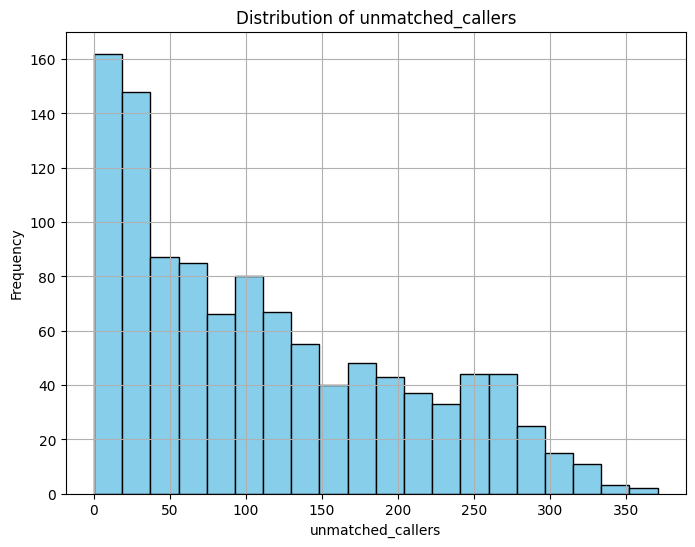

In [3519]:
plt.figure(figsize=(8, 6))
plt.hist(merged_calls_occupancy_flow_daily['unmatched_callers'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of unmatched_callers')
plt.xlabel('unmatched_callers')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


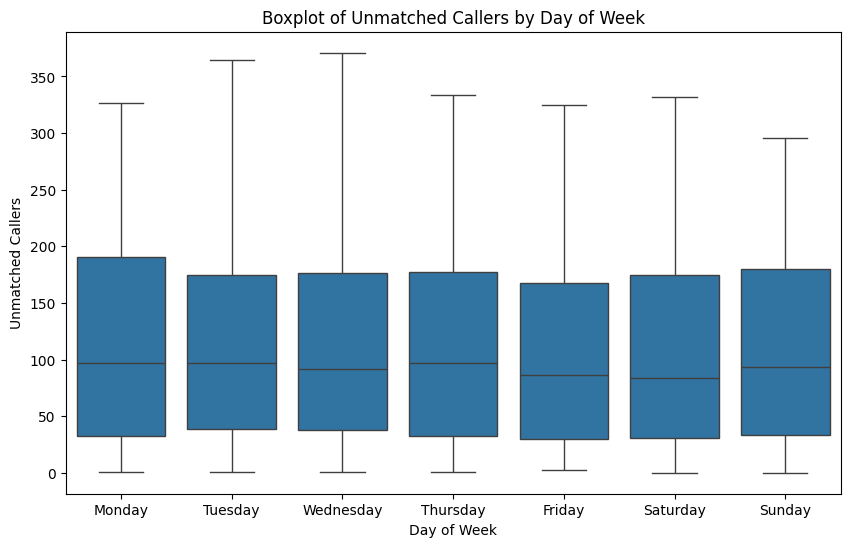

In [3520]:
weather_calls_occupancy_flow_daily = pd.merge(merged_calls_occupancy_flow_daily, weather, left_index=True, right_index=True, how='left')

weather_calls_occupancy_flow_daily['day_of_week'] = weather_calls_occupancy_flow_daily.index.dayofweek
weather_calls_occupancy_flow_daily['day_of_week'] = weather_calls_occupancy_flow_daily['day_of_week'].astype('category')
weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'] = weather_calls_occupancy_flow_daily['total_calls_handled'].shift(1)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='unmatched_callers', data=weather_calls_occupancy_flow_daily, order=sorted(weather_calls_occupancy_flow_daily['day_of_week'].unique()))
plt.title('Boxplot of Unmatched Callers by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Unmatched Callers')

plt.xticks(range(len(day_order)), day_order)

plt.show()

# ARIMA model

In [3521]:
weather_calls_occupancy_flow_daily = pd.merge(merged_calls_occupancy_flow_daily, weather, left_index=True, right_index=True, how='left')
weather_calls_occupancy_flow_daily.head()

,occupancy_rate,unmatched_callers,total_calls_handled,cold_season,returned_from_housing,returned_to_shelter,newly_identified,became_inactive,min_temp_cels,total_precip_mm,day_of_week,day_1,day_2,day_3,day_4,day_5,day_6
Date,,,,,,,,,,,,,,,,,
2021-01-01,92.83,19,305,1,84,425,647,660,-4.1,8.0,4,0,0,0,1,0,0
2021-01-02,92.99,22,319,1,84,425,647,660,-2.5,6.8,5,0,0,0,0,1,0
2021-01-03,92.64,28,281,1,84,425,647,660,-0.8,1.6,6,0,0,0,0,0,1
2021-01-04,92.15,28,379,1,84,425,647,660,-0.8,0.0,0,0,0,0,0,0,0
2021-01-05,92.06,45,461,1,84,425,647,660,-0.1,0.2,1,1,0,0,0,0,0


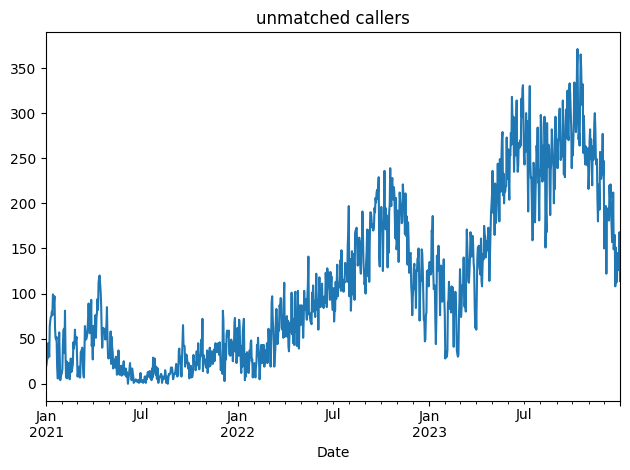

In [3522]:
weather_calls_occupancy_flow_daily.unmatched_callers.plot(title='unmatched callers')
plt.tight_layout(); plt.show()

In [3523]:
result = adfuller(weather_calls_occupancy_flow_daily.unmatched_callers)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.2345176212828834
p-value: 0.6585737040510949


As can be deduced from the time-series plot, the variable is non-stationary: both linear trend and seasonality is observed. This is proved by Adfuller stationarity test as well. Need to do differencing to get rid of linear trend.

In [3524]:
diff_unmatched_callers = weather_calls_occupancy_flow_daily['unmatched_callers'].diff().dropna()

# Perform the Augmented Dickey-Fuller test on the differenced data
result = adfuller(diff_unmatched_callers, regression='ct')
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -8.345240926376022
p-value: 1.1393582206599506e-11


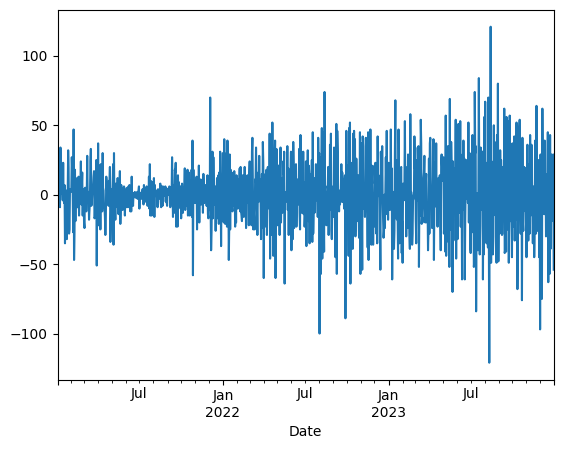

In [3525]:
diff_unmatched_callers.plot()
plt.show()

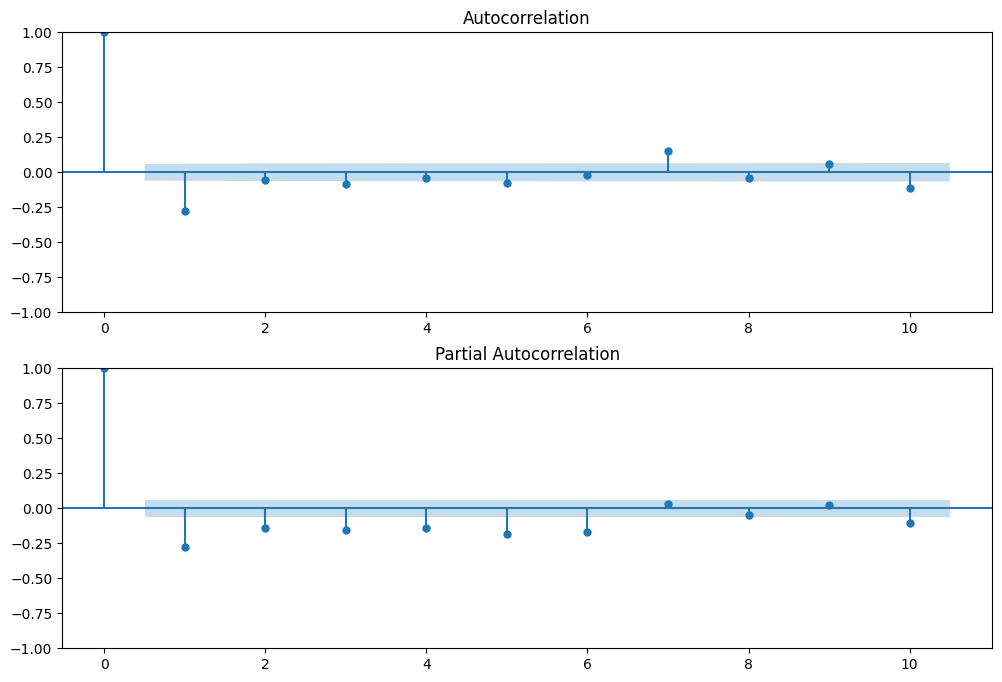

In [3526]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df
plot_acf(diff_unmatched_callers, lags=10, ax=ax1)

# Plot the PACF of df
plot_pacf(diff_unmatched_callers, lags=10,  ax=ax2)

plt.show()


In [3527]:
weather_calls_occupancy_flow_daily.index.freq = 'D'

order_aic_bic = []

for p in range(5):
    for q in range(5):
        try:
            try_model = ARIMA(weather_calls_occupancy_flow_daily.unmatched_callers, order=(p, 1, q), freq='D')
            try_results = try_model.fit()

            order_aic_bic.append((p, q, try_results.aic, try_results.bic))

        except Exception as e:
            print(f"Error for p={p}, q={q}: {e}")
            order_aic_bic.append((p, q, None, None))

order_aic_bic = pd.DataFrame(order_aic_bic, columns=['AR', 'MA', 'AIC', 'BIC'])
top_models = order_aic_bic.dropna().sort_values(by='BIC').head(5)
print(top_models)


    AR  MA          AIC          BIC
18   3   3  9920.267005  9955.250177
24   4   4  9916.713538  9961.691902
6    1   1  9958.362803  9973.355591
13   2   3  9945.130318  9975.115893
3    0   3  9959.128894  9979.119278


In [3528]:
model_arima = ARIMA(weather_calls_occupancy_flow_daily.unmatched_callers, order=(3,1,3))
results_arima = model_arima.fit()

predictions_arima = results_arima.predict()

mae_arima = mean_absolute_error(weather_calls_occupancy_flow_daily.unmatched_callers, predictions_arima)

print(f'Mean Absolute Error (MAE): {mae_arima}')
print(results_arima.bic)

Mean Absolute Error (MAE): 16.690393971632638
9955.250177345364


In [3529]:
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:      unmatched_callers   No. Observations:                 1095
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -4953.134
Date:                Sat, 09 Mar 2024   AIC                           9920.267
Time:                        00:13:26   BIC                           9955.250
Sample:                    01-01-2021   HQIC                          9933.505
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4515      0.054     26.929      0.000       1.346       1.557
ar.L2         -1.2734      0.068    -18.686      0.000      -1.407      -1.140
ar.L3          0.2704      0.050      5.379      0.0

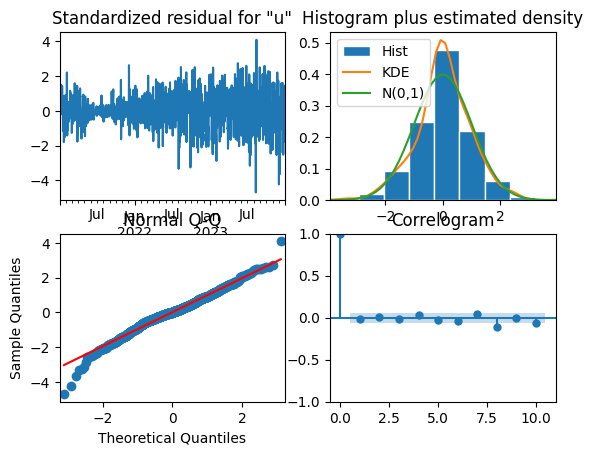

In [3530]:
results_arima.plot_diagnostics()
plt.show()

# Rolling 2023 predictions

In [3541]:
cutoff_date = pd.to_datetime('2023-01-01')
train_data = weather_calls_occupancy_flow_daily[:cutoff_date]
test_data = weather_calls_occupancy_flow_daily[cutoff_date:]
weather_calls_occupancy_flow_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2021-01-01 to 2023-12-31
Freq: D
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   occupancy_rate         1095 non-null   float64
 1   unmatched_callers      1095 non-null   int64  
 2   total_calls_handled    1095 non-null   int64  
 3   cold_season            1095 non-null   int64  
 4   returned_from_housing  1095 non-null   int64  
 5   returned_to_shelter    1095 non-null   int64  
 6   newly_identified       1095 non-null   int64  
 7   became_inactive        1095 non-null   int64  
 8   min_temp_cels          1095 non-null   float64
 9   total_precip_mm        1095 non-null   float64
 10  day_of_week            1095 non-null   int32  
 11  day_1                  1095 non-null   int64  
 12  day_2                  1095 non-null   int64  
 13  day_3                  1095 non-null   int64  
 14  day_4                  1095 no

In [3546]:
history_arima = train_data['unmatched_callers'].tolist()

predictions_arima_rolling = []

for t in range(len(test_data)):
    model_arima_rolling = ARIMA(history_arima, order=(3,1,3))
    model_fit = model_arima_rolling.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima_rolling.append(yhat)
    
    obs = test_data.iloc[t]['unmatched_callers']
    history_arima.append(obs)

mae_arima_rolling = mean_absolute_error(test_data['unmatched_callers'], predictions_arima_rolling)
print(f"ARIMA's MAE on the test data: {mae_arima_rolling:.3f}")

ARIMA's MAE on the test data: 23.009


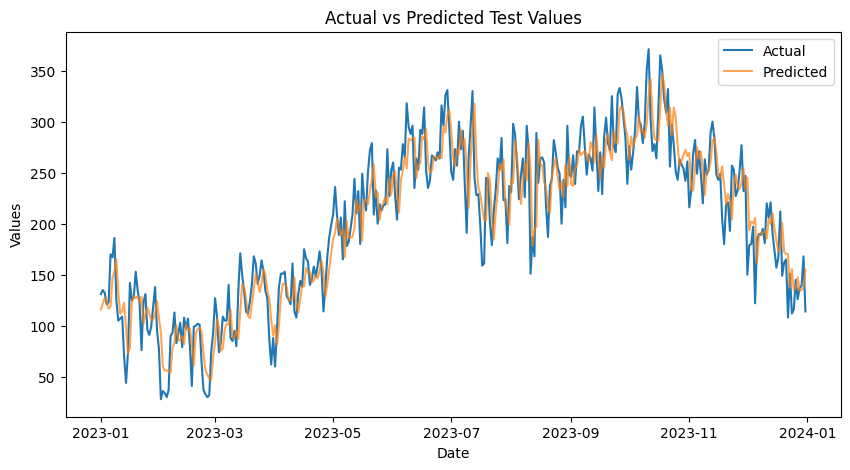

In [3547]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data.unmatched_callers, label='Actual')
plt.plot(test_data.index, predictions_arima_rolling, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Test Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

# SARIMAX

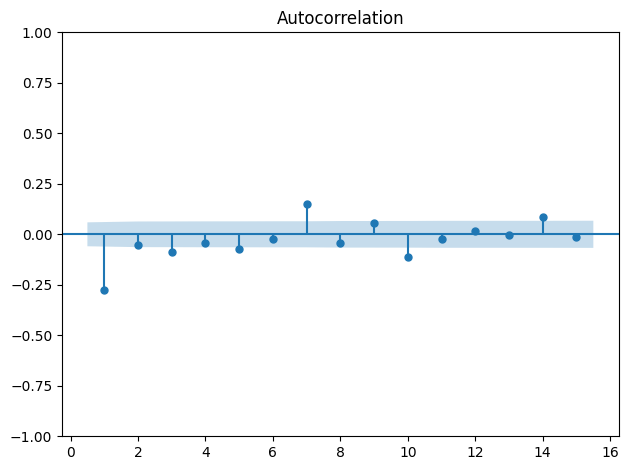

In [3548]:
lags = [1,7,14,21,28]

plot_acf(diff_unmatched_callers, lags=15, zero=False)
ax1.set_title('Autocorrelation Function (ACF)')

plt.tight_layout()
plt.show()


We observe weekly seasonality

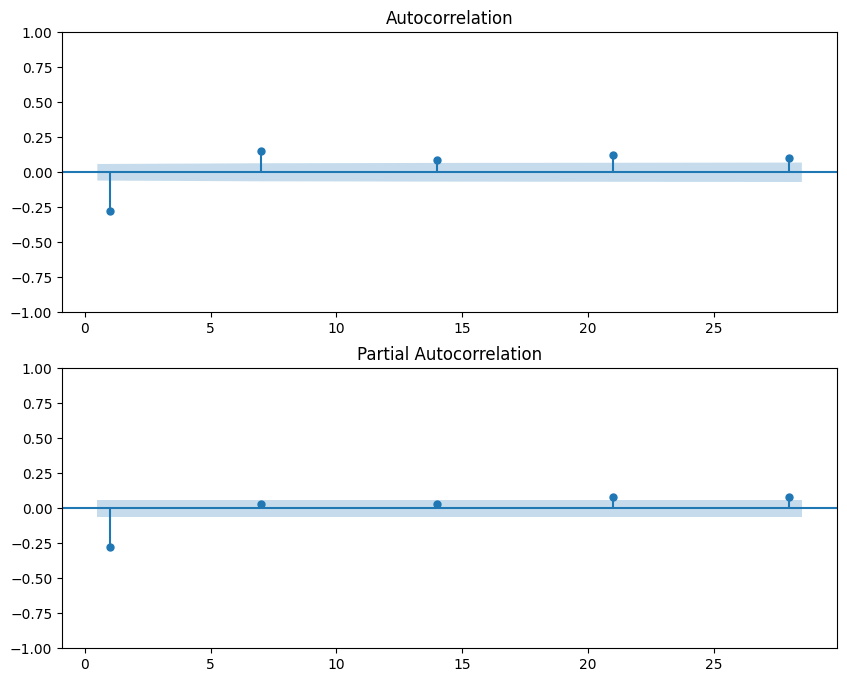

In [3549]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

plot_acf(diff_unmatched_callers, lags = lags, ax = ax1)
plot_pacf(diff_unmatched_callers, lags = lags, ax = ax2)

plt.show()

# Model Tuning

What is the best set of sarimax parameters and exogenous variables?


In [3550]:
model_auto = pm.auto_arima(weather_calls_occupancy_flow_daily.unmatched_callers,
                        seasonal=True, m=7,
                        d=1, D=1,
                        max_p=2, max_q=2,
                        error_action='ignore',
                        suppress_warnings=True)

print(model_auto.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1095
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood               -4937.506
Date:                                Sat, 09 Mar 2024   AIC                           9889.013
Time:                                        00:25:41   BIC                           9923.951
Sample:                                    01-01-2021   HQIC                          9902.238
                                         - 12-31-2023                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4559      0.037     12.385      0.000       0.384       0.528
ar.

In [3551]:
model_sarima = SARIMAX(weather_calls_occupancy_flow_daily.unmatched_callers,  
                       order=(2, 1, 1), 
                       seasonal_order=(1, 0, 1, 7))

results_sarima = model_sarima.fit(disp=0)
predictions_sarima = results_sarima.predict()

mae_sarima = mean_absolute_error(weather_calls_occupancy_flow_daily.unmatched_callers, predictions_sarima)

print("SARIMA's MAE: {}".format(mae_sarima.round(2)))
print('MAE improved: {}%'.format((100*((mae_arima - mae_sarima)/mae_arima)).round(2)))
print('BIC improved: {}%'.format((100*((results_arima.bic - results_sarima.bic)/results_arima.bic)).round(2)))

SARIMA's MAE: 16.67
MAE improved: 0.11%
BIC improved: 0.17%


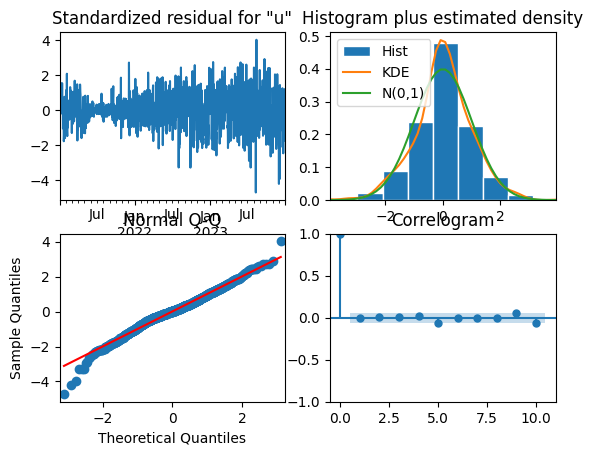

In [3552]:
results_sarima.plot_diagnostics()
plt.show()

In [3556]:
history_sarima = train_data['unmatched_callers'].tolist()
predictions_sarima_rolling = list()

for t in range(len(test_data)):
    model_sarima_rolling = SARIMAX(history_sarima, order=(2,1,1), seasonal_order=(1,0,1,7))
    model_fit = model_sarima_rolling.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions_sarima_rolling.append(yhat)
    obs = test_data.iloc[t]['unmatched_callers']
    history_sarima.append(obs)

mae_sarima_rolling = mean_absolute_error(test_data.unmatched_callers, predictions_sarima_rolling)
print("SARIMA's MAE on the test data: %.3f" % mae_sarima_rolling)

SARIMA's MAE on the test data: 22.684


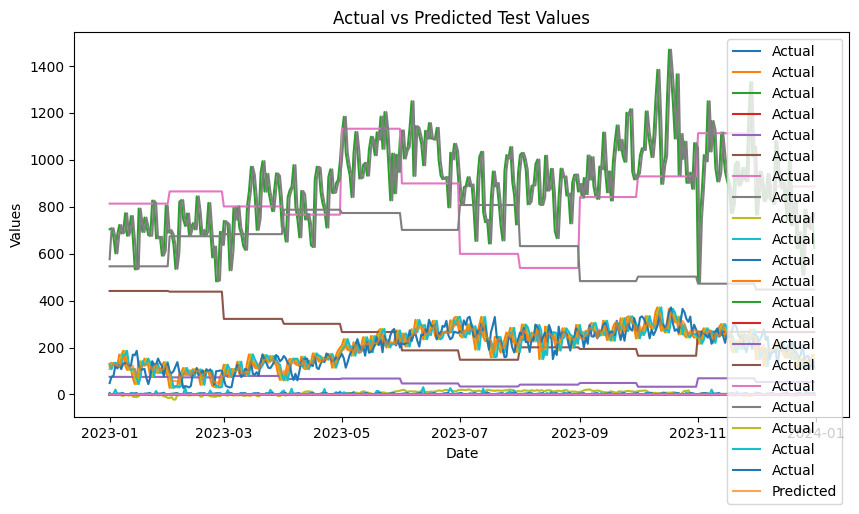

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, predictions_sarima_rolling, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Test Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

# Exogenous Feature Selection 

In [ ]:
weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'] = weather_calls_occupancy_flow_daily['total_calls_handled'].shift(1)
weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'] = weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'].ffill()
weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'] = weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'].bfill()

print(weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'].isna())

Date
2021-01-08    False
2021-01-09    False
2021-01-10    False
2021-01-11    False
2021-01-12    False
              ...  
2023-12-27    False
2023-12-28    False
2023-12-29    False
2023-12-30    False
2023-12-31    False
Freq: D, Name: total_calls_handled_lag_day, Length: 1088, dtype: bool


In [ ]:
weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'] = weather_calls_occupancy_flow_daily['occupancy_rate'].shift(1)



In [3456]:
weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'] = weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'].ffill()
weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'] = weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'].bfill()

weather_calls_occupancy_flow_daily = weather_calls_occupancy_flow_daily.drop('occupancy_rate', axis=1)
weather_calls_occupancy_flow_daily.head()

,unmatched_callers,total_calls_handled,cold_season,returned_from_housing,returned_to_shelter,newly_identified,became_inactive,min_temp_cels,total_precip_mm,day_of_week,...,day_2,day_3,day_4,day_5,day_6,total_calls_handled_lag_day,unmatched_callers_lag_day,unmatched_callers_lag_twodays,unmatched_callers_lag_week,occupancy_rate_lag_day
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-08,64,475,1,84,425,647,660,-9.3,0.0,4,...,0,0,1,0,0,475.0,30.0,39.0,19.0,93.11
2021-01-09,70,506,1,84,425,647,660,-4.3,0.0,5,...,0,0,0,1,0,475.0,64.0,30.0,22.0,93.11
2021-01-10,74,477,1,84,425,647,660,-5.6,0.0,6,...,0,0,0,0,1,506.0,70.0,64.0,28.0,93.26
2021-01-11,75,529,1,84,425,647,660,-6.1,0.0,0,...,0,0,0,0,0,477.0,74.0,70.0,28.0,92.87
2021-01-12,80,499,1,84,425,647,660,-2.1,0.0,1,...,0,0,0,0,0,529.0,75.0,74.0,45.0,92.99


In [3457]:
endog = weather_calls_occupancy_flow_daily.unmatched_callers

exog_features = weather_calls_occupancy_flow_daily.drop(['unmatched_callers', 'total_calls_handled'], axis=1)
feature_names = exog_features.columns

best_feature = None

best_bic = float('inf')
current_features = []

while True:
    improvement = False
    for feature in exog_features.columns.difference(current_features):
        try:
            model = SARIMAX(endog, exog=exog_features[current_features + [feature]], 
                            order=(2,1,1), seasonal_order=(1,0,1,7), enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=0)

            if results.bic < best_bic:
                best_bic = results.bic
                best_feature = feature
                improvement = True
        except:
            continue

    if improvement:
        current_features.append(best_feature)
        print(f"Added {best_feature}, BIC: {best_bic}")
    else:
        break

print(f"Final features: {current_features}")

Added min_temp_cels, BIC: 9795.19679902407
Added unmatched_callers_lag_week, BIC: 9794.68699879599
Final features: ['min_temp_cels', 'unmatched_callers_lag_week']


In [3438]:
model_sarima = SARIMAX(weather_calls_occupancy_flow_daily.unmatched_callers,  
                       exog = weather_calls_occupancy_flow_daily[current_features],
                       order=(2, 1, 1), 
                       seasonal_order=(1, 1, 1, 7))

results_sarima = model_sarima.fit(disp=0)
predictions_sarima = results_sarima.predict()

mae_sarima = mean_absolute_error(weather_calls_occupancy_flow_daily.unmatched_callers, predictions_sarima)
print("SARIMA's MAE: {}".format(mae_sarima.round(4)))

SARIMA's MAE: 17.4938


In [3417]:
print(results_sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                 unmatched_callers   No. Observations:                 1088
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4890.373
Date:                           Thu, 07 Mar 2024   AIC                           9796.746
Time:                                   17:30:46   BIC                           9836.624
Sample:                               01-08-2021   HQIC                          9811.846
                                    - 12-31-2023                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
min_temp_cels      0.9475      0.207      4.577      0.000       0.542       1.353
occupancy_rate     5.1781      

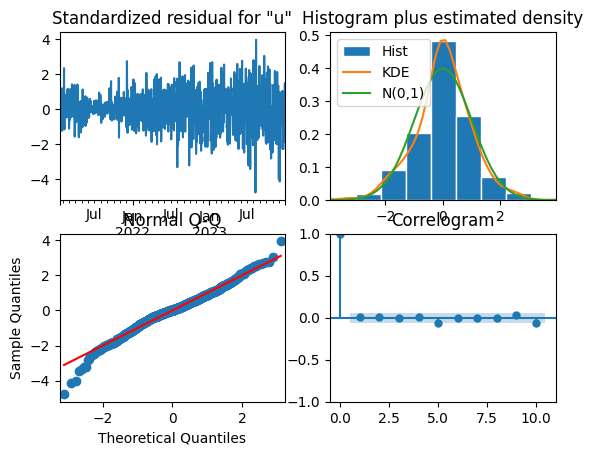

In [3412]:
results_sarima.plot_diagnostics()
plt.show()

Assume that temperature can be forecasted a day prior, and occupancy_rate cannot. That means, we need to add a day-lag to occupancy_rate.

In [3442]:


train_endog = train_data['unmatched_callers']
test_sarimax = test_data['unmatched_callers']
train_exog = train_data[current_features]
test_exog = test_data[current_features]

history_endog = [x for x in train_endog]
history_exog = train_exog.values.tolist()  
predictions_sarimax = []

for t in range(len(test_sarimax)):
    model = SARIMAX(history_endog, exog=history_exog,
                    order=(2, 1, 1),  
                    seasonal_order=(1, 0, 1, 7))
    model_fit = model.fit(disp=0)
    
    next_exog = test_exog.iloc[t:t+1].values  
    
    output = model_fit.forecast(exog=next_exog)
    yhat = output[0]
    predictions_sarimax.append(yhat)
    
    obs = test_sarimax.iloc[t]
    history_endog.append(obs)

    history_exog.append(next_exog[0].tolist())  

mae_sarimax = mean_absolute_error(test_sarimax, predictions_sarimax)
print("Mean Absolute Error (MAE) on test data:", mae_sarimax)

Mean Absolute Error (MAE) on test data: 22.483440416327262


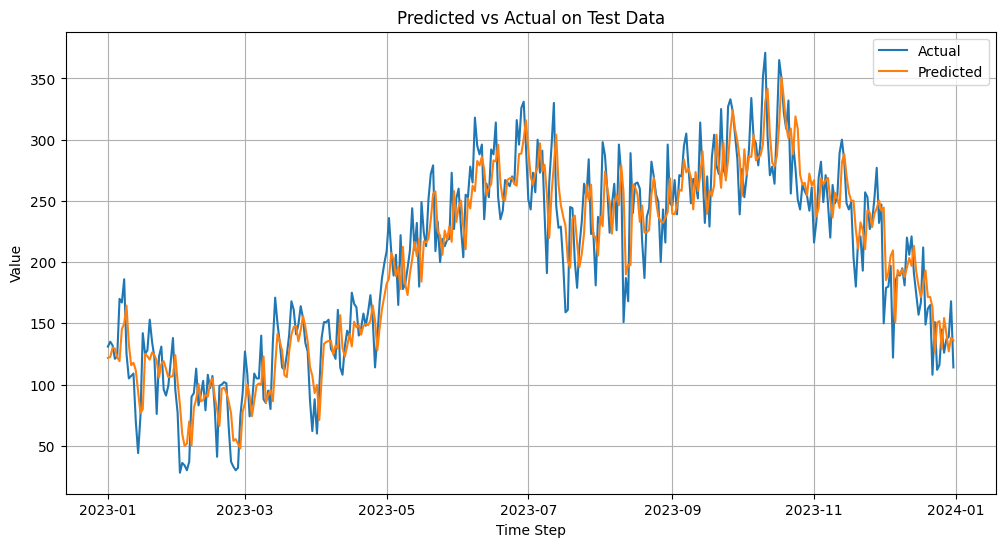

In [3278]:
plt.figure(figsize=(12, 6))
plt.plot(test_sarimax.index, test_sarimax, label='Actual')
plt.plot(test_sarimax.index, predictions_sarimax, label='Predicted')
plt.title('Predicted vs Actual on Test Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# OTHER MODELS

# Feature Engineering

In [3392]:
weather_calls_occupancy_flow_daily = pd.DataFrame()
weather_calls_occupancy_flow_daily.columns

weather_calls_occupancy_flow_daily = pd.merge(merged_calls_occupancy_flow_daily, weather, left_index=True, right_index=True, how='left')

weather_calls_occupancy_flow_daily['day_of_week'] = weather_calls_occupancy_flow_daily.index.dayofweek
weather_calls_occupancy_flow_daily['day_of_week'] = weather_calls_occupancy_flow_daily['day_of_week'].astype('category')

weather_calls_occupancy_flow_daily['unmatched_callers_lag_day'] = weather_calls_occupancy_flow_daily['unmatched_callers'].shift(1)
weather_calls_occupancy_flow_daily['unmatched_callers_lag_day'] = weather_calls_occupancy_flow_daily['unmatched_callers_lag_day'].ffill()

weather_calls_occupancy_flow_daily['unmatched_callers_lag_twodays'] = weather_calls_occupancy_flow_daily['unmatched_callers_lag_day'].shift(1)
weather_calls_occupancy_flow_daily['unmatched_callers_lag_twodays'] = weather_calls_occupancy_flow_daily['unmatched_callers_lag_twodays'].ffill()

weather_calls_occupancy_flow_daily['unmatched_callers_lag_week'] = weather_calls_occupancy_flow_daily['unmatched_callers'].shift(7)
weather_calls_occupancy_flow_daily['unmatched_callers_lag_week'] = weather_calls_occupancy_flow_daily['unmatched_callers_lag_week'].ffill()

weather_calls_occupancy_flow_daily.dropna(inplace=True)


# Linear Regression

# Future Selection

In [3400]:
train_data = weather_calls_occupancy_flow_daily[:cutoff_date]
test_data = weather_calls_occupancy_flow_daily[cutoff_date:]

In [3401]:
initial_features = ['occupancy_rate',
       'cold_season', 'returned_from_housing', 'returned_to_shelter',
       'newly_identified', 'became_inactive', 'min_temp_cels',
       'total_precip_mm', 'day_of_week',
       'total_calls_handled_lag_day', 'total_calls_handled_lag_day',
       'unmatched_callers_lag_week', 'unmatched_callers_lag_day', 'unmatched_callers_lag_twodays']

history_y = train_data['unmatched_callers'].values
selected_features = []

# Track performance improvement
best_mae = np.inf
improvement = True

while improvement:
    improvement = False
    for feature in initial_features:
        if feature not in selected_features:
            # Try adding this feature
            temp_features = selected_features + [feature]
            
            # Reinitialize history_X with the current set of features
            history_X = train_data[temp_features]
            
            predictions_temp = []
            for t in range(len(test_data)):
                # Note: In a real rolling forecast, you'd retrain here with the growing history_X
                # For simplicity, we're training once per iteration before the loop for demonstration
                model_temp = LinearRegression().fit(history_X, history_y)
                
                next_row = test_data.iloc[[t]]
                next_X = next_row[temp_features]
                yhat = model_temp.predict(next_X)[0]
                predictions_temp.append(yhat)
            
            temp_mae = mean_absolute_error(test_data['unmatched_callers'], predictions_temp)
            
            # Check if the temporary feature set gives better performance
            if temp_mae < best_mae:
                best_mae = temp_mae
                best_feature = feature
                improvement = True
    
    # If an improvement was found, update the selected features and the best MAE
    if improvement:
        selected_features.append(best_feature)
        print(f"Added {best_feature}, New best MAE: {best_mae}")

# Final selected features and performance
print(f"Selected features: {selected_features}")
print(f"Best MAE with selected features: {best_mae}")


Added unmatched_callers_lag_day, New best MAE: 25.801356184367464
Added unmatched_callers_lag_week, New best MAE: 23.878839504254184
Added unmatched_callers_lag_twodays, New best MAE: 23.52256618446129
Added returned_to_shelter, New best MAE: 23.37662083809538
Added newly_identified, New best MAE: 23.268505544945405
Added min_temp_cels, New best MAE: 23.21216988668201
Added returned_from_housing, New best MAE: 23.178817629753006
Selected features: ['unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'unmatched_callers_lag_twodays', 'returned_to_shelter', 'newly_identified', 'min_temp_cels', 'returned_from_housing']
Best MAE with selected features: 23.178817629753006


# Building Model

In [3404]:
train_data = weather_calls_occupancy_flow_daily[weather_calls_occupancy_flow_daily.index < cutoff_date]
test_data = weather_calls_occupancy_flow_daily[weather_calls_occupancy_flow_daily.index >= cutoff_date]

history_X = train_data[['unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'returned_to_shelter', 'min_temp_cels', 'occupancy_rate', 'unmatched_callers_lag_twodays']]
history_y = train_data['unmatched_callers'].values 

predictions_linear = []

for t in range(len(test_data)):
    model_linear = LinearRegression()
    model_linear.fit(history_X, history_y)  
    
    next_row = test_data.iloc[t:t+1]  
    next_X = next_row[['unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'returned_to_shelter', 'min_temp_cels', 'occupancy_rate', 'unmatched_callers_lag_twodays']]
    
    yhat = model_linear.predict(next_X)[0]  
    predictions_linear.append(yhat)  
    
    true_value = next_row['unmatched_callers'].values[0]
    history_y = np.append(history_y, true_value)  
    history_X = pd.concat([history_X, next_X], ignore_index=True)

mae_linear_rolling = mean_absolute_error(test_data.unmatched_callers, predictions_linear)
print("Mean Absolute Error (MAE) on test data with rolling forecast:", mae_linear_rolling)


Mean Absolute Error (MAE) on test data with rolling forecast: 23.126372277170596


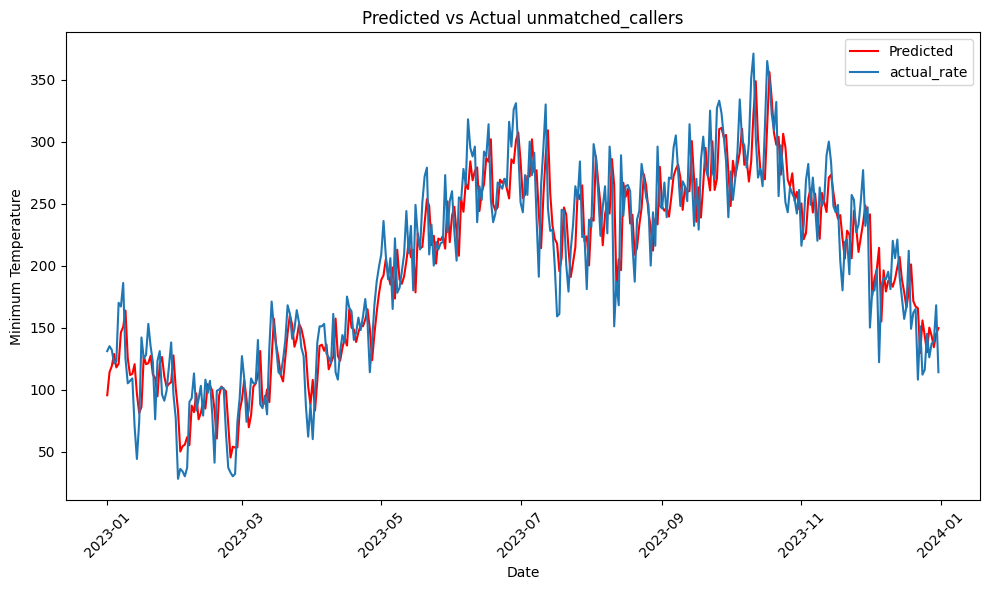

In [3387]:
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, predictions_linear, label='Predicted', c= 'r')
plt.plot(test_data.index, test_data.unmatched_callers, label='actual_rate')
plt.xlabel('Date')
plt.ylabel('Minimum Temperature')
plt.title('Predicted vs Actual unmatched_callers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [3389]:
feature_importance = model_linear.coef_
feature_names = ['unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'returned_to_shelter', 'min_temp_cels', 'occupancy_rate', 'unmatched_callers_lag_twodays']
feature_importance_flat = feature_importance.flatten()

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_flat})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)


Feature Importance:
                           Feature  Importance
4                   occupancy_rate    1.939644
0        unmatched_callers_lag_day    0.619092
3                    min_temp_cels    0.338115
1       unmatched_callers_lag_week    0.229334
5  total_calls_handled_lag_twodays    0.019651
2              returned_to_shelter   -0.042571


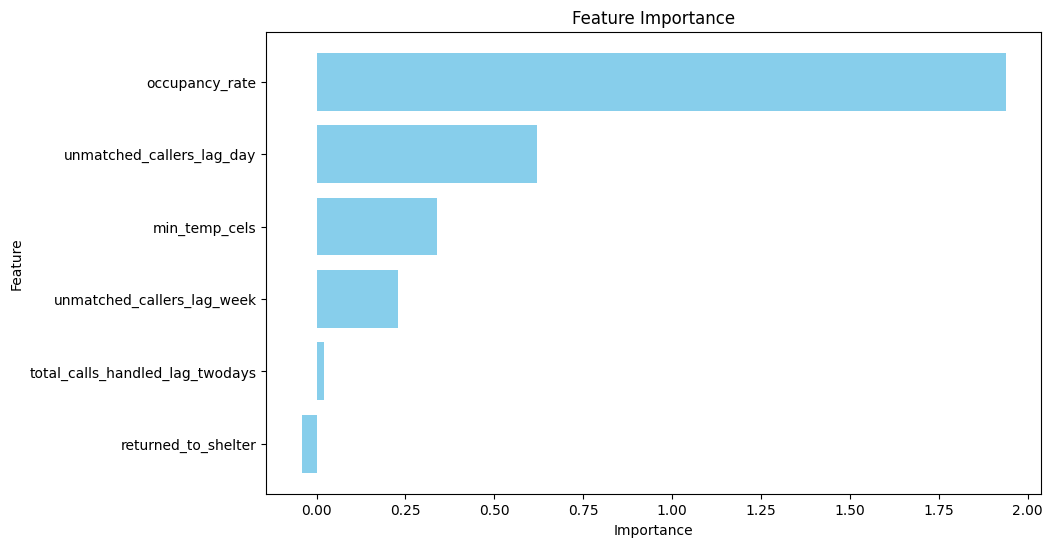

In [3390]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show() 

# Light GBM


In [3372]:
initial_features = ['occupancy_rate', 'cold_season', 'returned_from_housing', 'returned_to_shelter',
                    'newly_identified', 'became_inactive', 'min_temp_cels', 'total_precip_mm', 'day_of_week',
                    'total_calls_handled_lag_day', 'unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'total_calls_handled_lag_twodays']
selected_features = []

history_y = train_data['unmatched_callers'].values
best_mae = np.inf
improvement = True

while improvement:
    improvement = False
    best_feature = None
    for feature in initial_features:
        if feature not in selected_features:
            # Try adding this feature
            temp_features = selected_features + [feature]
            history_X = train_data[temp_features]

            model_temp = lgb.LGBMRegressor()

            model_temp.fit(history_X, history_y)

            # Making predictions on the test set
            next_X_test = test_data[temp_features]
            predictions_temp = model_temp.predict(next_X_test)

            # Calculate the MAE with this temporary set of features
            temp_mae = mean_absolute_error(test_data['unmatched_callers'], predictions_temp)

            # Check if we have found a better set of features
            if temp_mae < best_mae:
                best_mae = temp_mae
                best_feature = feature
                improvement = True

    # If an improvement was found, update the selected features and the best MAE
    if best_feature:
        selected_features.append(best_feature)
        print(f"Added {best_feature}, New best MAE: {best_mae}")

# Final selected features and performance
print(f"Selected features: {selected_features}")
print(f"Best MAE with selected features: {best_mae}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 723, number of used features: 1
[LightGBM] [Info] Start training from score 68.015214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [3454]:
history_X = train_data[['unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'min_temp_cels', 'occupancy_rate', 'unmatched_callers_lag_twodays']]
history_y = train_data['unmatched_callers'].values 

predictions_lgbm = []
model_lgbm = lgb.LGBMRegressor()

for t in range(len(test_data)):
    
    model_lgbm.fit(history_X, history_y)
    
    next_row = test_data.iloc[t:t+1]
    next_X = next_row[['unmatched_callers_lag_day',  'unmatched_callers_lag_week', 'min_temp_cels', 'occupancy_rate', 'unmatched_callers_lag_twodays']]
    
    yhat = model_lgbm.predict(next_X)[0]
    predictions_lgbm.append(yhat)
    
    true_value = next_row['unmatched_callers'].values[0]
    history_y = np.append(history_y, true_value)
    # Correctly append the next_X row to history_X
    history_X = pd.concat([history_X, next_X], ignore_index=True)

mae_lgbm_rolling = mean_absolute_error(test_data['unmatched_callers'], predictions_lgbm)
print("Mean Absolute Error (MAE) on test data with rolling forecast using LightGBM:", mae_lgbm_rolling)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 723, number of used features: 6
[LightGBM] [Info] Start training from score 68.015214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

no return - 24.66


In [3453]:
feature_importances = model_lgbm.feature_importances_

feature_names = history_X.columns.tolist()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                         Feature  Importance
0      unmatched_callers_lag_day         684
3                 occupancy_rate         641
1     unmatched_callers_lag_week         624
4  unmatched_callers_lag_twodays         572
2                  min_temp_cels         479


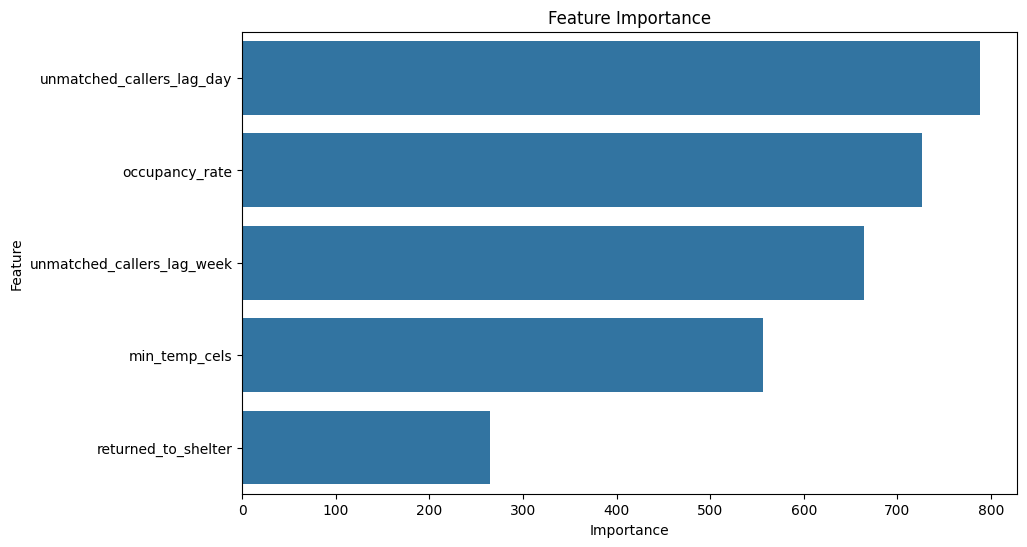

In [3366]:
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# XGBOOST

In [3443]:
features = ['unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'returned_to_shelter', 'min_temp_cels', 'occupancy_rate', 'unmatched_callers_lag_twodays']
target = 'unmatched_callers'

# Prepare your initial training set
history_X = train_data[features]
history_y = train_data[target].values

predictions_xgb = []
model_xgb = xgb.XGBRegressor(n_estimators = 1000)

for t in range(len(test_data)):

    model_xgb.fit(history_X, history_y)
    
    # Predict the next time step
    next_row = test_data.iloc[[t]]
    next_X = next_row[features]
    yhat = model_xgb.predict(next_X)[0]
    predictions_xgb.append(yhat)
    
    # Update the training set with the true value
    true_value = next_row[target].values[0]
    history_y = np.append(history_y, true_value)
    history_X = pd.concat([history_X, next_X], ignore_index=True)

# Calculate and print the MAE
mae_xgb_rolling = mean_absolute_error(test_data[target], predictions_xgb)
print("Mean Absolute Error (MAE) on test data with rolling forecast using XGBoost:", mae_xgb_rolling)


Mean Absolute Error (MAE) on test data with rolling forecast using XGBoost: 26.392331026678217


# CONCLUSION